In [1]:
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
import seaborn as sns
import pandas as pd
import pickle

## Data pre-processing

In [27]:
# Utility functions
def load_data():
    """load data."""
    f = open(f"dataset/x_train.csv")
    features = f.readline()
    feature_names = features.split(',')
    data = np.loadtxt(f"dataset/x_train.csv", delimiter=",", skiprows=1, dtype=str)
    return data,feature_names

def convert_row_to_float(row):
    """Convert values in row to float or np.nan."""
    new_row = []
    for item in row:
        try:
            new_row.append(float(item))
        except ValueError:
            new_row.append(np.nan)
    return np.array(new_row)

def convert_all_rows(data):
    """Convert all rows to float or np.nan."""
    new_data = []
    for row in data:
        new_data.append(convert_row_to_float(row))
    return np.array(new_data)

def column_NAN(array):
    nan=0
    for i in range(len(array)):
        if np.isnan(array[i]):
                nan += 1
    return nan

def train_validation_split(data, ratio, seed):
    """Split data into training and validation set."""
    np.random.seed(seed)
    np.random.shuffle(data)
    split_index = int(len(data) * ratio)
    return data[:split_index], data[split_index:]

def k_fold_split(data, k, seed):
    """Split data into k folds."""
    np.random.seed(seed)
    np.random.shuffle(data)
    return np.array_split(data, k)

def standardize_data(data):
    """Standardize data."""
    mean = np.nanmean(data, axis=0)
    std = np.nanstd(data, axis=0)
    return (data - mean) / std

def number_of_NaNs(list_,data):
    NaNs=np.zeros(len(list_))
    for i in list_:
        NaNs[list_.index(i)]=column_NAN(data[:,list_.index(i)])
    return NaNs

def removing_features(number_NaN,list_,data):
    Removed_features=[]
    for i in range(len(number_NaN)):
        if number_NaN[i] > round(len(data))*0.1:
            Removed_features.append(i)
    reduced_data = np.delete(data, Removed_features, 1)
    reduced_list = list(filter(lambda x: list_.index(x) not in Removed_features, list_))
    return reduced_data, reduced_list

def clean_outliers(X):
    for column in range(X.shape[1]):  # for each feature:
        # calculating 25th and 75th quantiles
        q1_X = np.nanquantile(X[:, column], 0.25, axis=0)
        q3_X = np.nanquantile(X[:, column], 0.75, axis=0)
        IQR_X = q3_X - q1_X  # inter quantile range
        # calculating lower and upper bounds
        lower_bound = q1_X - 1.5 * IQR_X
        upper_bound = q3_X + 1.5 * IQR_X
        # finding which observations are outside/inside of the bounds
        above = X[:, column] > upper_bound
        below = X[:, column] < lower_bound
        outside = above | below
        inside = np.invert(outside)
        # calculate median value of observations that are inside boundaries
        median = np.median(X[inside, column])
        # setting outliers equal to median
        X[outside, column] = median
    return X

def replace_NaN_mean_column(column):
    mean=np.nanmean(column)
    for i in range(len(column)):
        if np.isnan(column[i]):
            column[i]=mean
    return column

def replace_NaN_median_column(column):
    median=np.nanmedian(column)
    for i in range(len(column)):
        if np.isnan(column[i]):
            column[i]=median
    return column


def replace_NaN(matrix, method='mean'): 
    for i in range(matrix.shape[1]):
        if method=='mean':
            matrix[:,i] = replace_NaN_mean_column(matrix[:,i])
        elif method=='median':
            matrix[:,i] = replace_NaN_median_column(matrix[:,i])
    return matrix

#### Loading data

In [17]:
numpy_data, features = load_data()

#### Converting to float

In [18]:
data = convert_all_rows(numpy_data)

In [5]:
data

array([[5.3000000e+01, 1.1000000e+01, 1.1162015e+07, ...,           nan,
                  nan, 2.0000000e+00],
       [3.3000000e+01, 1.2000000e+01, 1.2152015e+07, ...,           nan,
                  nan,           nan],
       [2.0000000e+01, 1.0000000e+01, 1.0202015e+07, ..., 1.0000000e+00,
        2.0000000e+00, 2.0000000e+00],
       ...,
       [3.9000000e+01, 1.0000000e+01, 1.0202015e+07, ..., 2.0000000e+00,
        2.0000000e+00, 2.0000000e+00],
       [3.3000000e+01, 1.2000000e+01, 1.2302015e+07, ...,           nan,
                  nan, 2.0000000e+00],
       [3.2000000e+01, 9.0000000e+00, 9.1220150e+06, ...,           nan,
                  nan, 2.0000000e+00]])

#### Removing id column in data

In [6]:
features

['_STATE',
 'FMONTH',
 'IDATE',
 'IMONTH',
 'IDAY',
 'IYEAR',
 'DISPCODE',
 'SEQNO',
 '_PSU',
 'CTELENUM',
 'PVTRESD1',
 'COLGHOUS',
 'STATERES',
 'CELLFON3',
 'LADULT',
 'NUMADULT',
 'NUMMEN',
 'NUMWOMEN',
 'CTELNUM1',
 'CELLFON2',
 'CADULT',
 'PVTRESD2',
 'CCLGHOUS',
 'CSTATE',
 'LANDLINE',
 'HHADULT',
 'GENHLTH',
 'PHYSHLTH',
 'MENTHLTH',
 'POORHLTH',
 'HLTHPLN1',
 'PERSDOC2',
 'MEDCOST',
 'CHECKUP1',
 'BPHIGH4',
 'BPMEDS',
 'BLOODCHO',
 'CHOLCHK',
 'TOLDHI2',
 'CVDSTRK3',
 'ASTHMA3',
 'ASTHNOW',
 'CHCSCNCR',
 'CHCOCNCR',
 'CHCCOPD1',
 'HAVARTH3',
 'ADDEPEV2',
 'CHCKIDNY',
 'DIABETE3',
 'DIABAGE2',
 'SEX',
 'MARITAL',
 'EDUCA',
 'RENTHOM1',
 'NUMHHOL2',
 'NUMPHON2',
 'CPDEMO1',
 'VETERAN3',
 'EMPLOY1',
 'CHILDREN',
 'INCOME2',
 'INTERNET',
 'WEIGHT2',
 'HEIGHT3',
 'PREGNANT',
 'QLACTLM2',
 'USEEQUIP',
 'BLIND',
 'DECIDE',
 'DIFFWALK',
 'DIFFDRES',
 'DIFFALON',
 'SMOKE100',
 'SMOKDAY2',
 'STOPSMK2',
 'LASTSMK2',
 'USENOW3',
 'ALCDAY5',
 'AVEDRNK2',
 'DRNK3GE5',
 'MAXDRNKS',
 'FRUITJU

#### Finding number of NaN for each feature

In [19]:
NaNs = number_of_NaNs(features,data)

#### Histogram NaN before removing colums

Text(0.5, 1.0, 'Number of NaNs per feature')

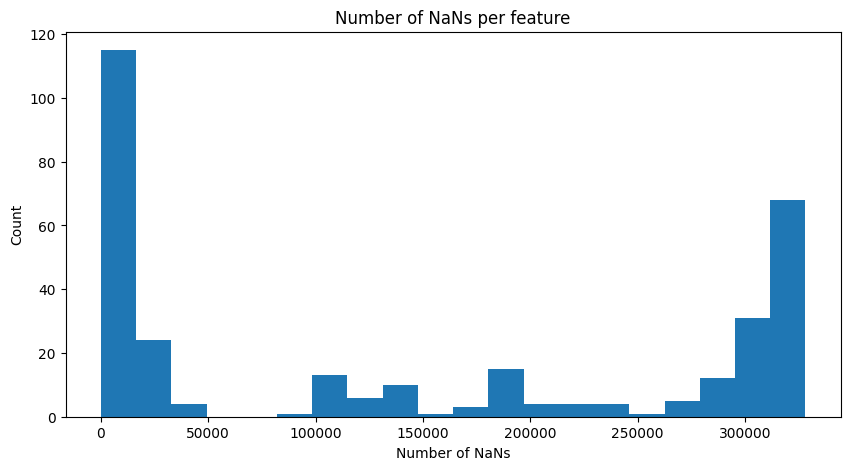

In [8]:
plt.figure(figsize=(10, 5))
plt.hist(NaNs, bins=20)
plt.xlabel("Number of NaNs")
plt.ylabel("Count")
plt.title("Number of NaNs per feature")

#### Removing features with too many NaNs

In [20]:
reduced_data, reduced_features = removing_features(NaNs,features,data)

#### Histogram NaNs after dropping features 

In [21]:
Reduced_NaNs = number_of_NaNs(reduced_features,reduced_data)

Text(0.5, 1.0, 'Number of NaNs per feature')

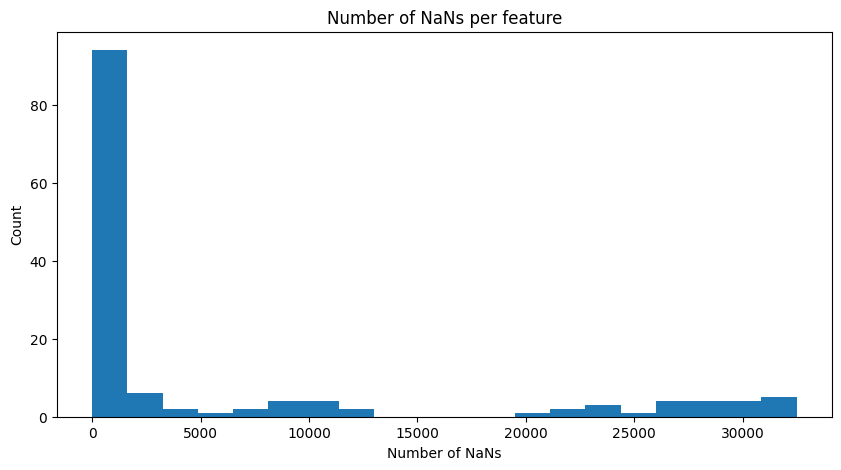

In [11]:
plt.figure(figsize=(10, 5))
plt.hist(Reduced_NaNs, bins=20)
plt.xlabel("Number of NaNs")
plt.ylabel("Count")
plt.title("Number of NaNs per feature")

Still quite a few features with a lot of NaNs (more than 20000) might consider increasing min level to 95 or 99%

#### Dealing with outliers

In [14]:
removed_outlier_data = clean_outliers(reduced_data)

#### Dealing with NaNs

In [15]:
removed_outlier_data

array([[1.1000000e+01, 1.1162015e+07, 1.1000000e+01, ..., 1.0000000e+00,
        1.0000000e+00, 2.0000000e+00],
       [1.2000000e+01, 1.2152015e+07, 1.2000000e+01, ..., 1.0000000e+00,
        1.0000000e+00,           nan],
       [1.0000000e+01, 1.0202015e+07, 1.0000000e+01, ..., 1.0000000e+00,
        1.0000000e+00, 2.0000000e+00],
       ...,
       [1.0000000e+01, 1.0202015e+07, 1.0000000e+01, ..., 1.0000000e+00,
        1.0000000e+00, 2.0000000e+00],
       [1.2000000e+01, 1.2302015e+07, 1.2000000e+01, ..., 1.0000000e+00,
        1.0000000e+00, 2.0000000e+00],
       [9.0000000e+00, 9.1220150e+06, 9.0000000e+00, ..., 1.0000000e+00,
        1.0000000e+00, 2.0000000e+00]])

### Here also for most categorical variables we might want to merge Together:
- Don't know 
- Refused
- NaN

In [22]:
# For each feature, show the number of unique values
features_below_10_unique_values = {}
for i in range(reduced_data.shape[1]):
    # print(f"{reduced_features[i]}: {len(np.unique(reduced_data[:,i]))}")
    print(f"{reduced_features[i]}: {np.unique(reduced_data[:,i])}")
    if len(np.unique(reduced_data[:,i])) < 10:
        features_below_10_unique_values[reduced_features[i]] = len(np.unique(reduced_data[:,i]))

_STATE: [ 1.  2.  4.  5.  6.  8.  9. 10. 11. 12. 13. 15. 16. 17. 18. 19. 20. 21.
 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39.
 40. 41. 42. 44. 45. 46. 47. 48. 49. 50. 51. 53. 54. 55. 56. 66. 72.]
FMONTH: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
IDATE: [ 1012016.  1022015.  1022016.  1032015.  1032016.  1042015.  1042016.
  1052015.  1052016.  1062015.  1062016.  1072015.  1072016.  1082015.
  1082016.  1092015.  1092016.  1102015.  1102016.  1112015.  1112016.
  1122015.  1122016.  1132015.  1132016.  1142015.  1142016.  1152015.
  1152016.  1162015.  1162016.  1172015.  1172016.  1182015.  1182016.
  1192015.  1192016.  1202015.  1202016.  1212015.  1212016.  1222015.
  1222016.  1232015.  1232016.  1242015.  1242016.  1252015.  1252016.
  1262015.  1262016.  1272015.  1272016.  1282015.  1282016.  1292015.
  1292016.  1302015.  1302016.  1312015.  1312016.  2012015.  2012016.
  2022015.  2022016.  2032015.  2032016.  2042015.  2042016.  2052015.
 

In [23]:
# Count the number of NaNs in each feature
for i in zip(features,NaNs):
    print(i)

('_STATE', 0.0)
('FMONTH', 0.0)
('IDATE', 0.0)
('IMONTH', 0.0)
('IDAY', 0.0)
('IYEAR', 0.0)
('DISPCODE', 0.0)
('SEQNO', 0.0)
('_PSU', 0.0)
('CTELENUM', 139415.0)
('PVTRESD1', 139415.0)
('COLGHOUS', 328103.0)
('STATERES', 139416.0)
('CELLFON3', 139415.0)
('LADULT', 328103.0)
('NUMADULT', 139433.0)
('NUMMEN', 139524.0)
('NUMWOMEN', 139525.0)
('CTELNUM1', 188720.0)
('CELLFON2', 188720.0)
('CADULT', 188721.0)
('PVTRESD2', 188720.0)
('CCLGHOUS', 327334.0)
('CSTATE', 188719.0)
('LANDLINE', 189287.0)
('HHADULT', 192544.0)
('GENHLTH', 2.0)
('PHYSHLTH', 1.0)
('MENTHLTH', 0.0)
('POORHLTH', 159860.0)
('HLTHPLN1', 0.0)
('PERSDOC2', 0.0)
('MEDCOST', 1.0)
('CHECKUP1', 1.0)
('BPHIGH4', 1.0)
('BPMEDS', 196334.0)
('BLOODCHO', 0.0)
('CHOLCHK', 43801.0)
('TOLDHI2', 43801.0)
('CVDSTRK3', 0.0)
('ASTHMA3', 0.0)
('ASTHNOW', 284153.0)
('CHCSCNCR', 1.0)
('CHCOCNCR', 0.0)
('CHCCOPD1', 0.0)
('HAVARTH3', 1.0)
('ADDEPEV2', 0.0)
('CHCKIDNY', 0.0)
('DIABETE3', 5.0)
('DIABAGE2', 285915.0)
('SEX', 0.0)
('MARITAL', 0.0

In [25]:
def create_dictionary_from_correlation(correlation_threshold):
    newfeature_correlation_dict = {}
    # For each feature in the dataset calculate the correlation with the others and save those which have higher than 0.6 correlation
    for ft_num, feature in enumerate(reduced_features):
        newfeature_correlation_dict[feature] = []
        for o_ft_num, other_feature in enumerate(reduced_features):
            if (feature != other_feature):
                if np.abs(np.corrcoef(reduced_data[:,ft_num],reduced_data[:,o_ft_num])[0,1]) >= correlation_threshold:
                    newfeature_correlation_dict[feature].append(other_feature)
        print(f" Finished for feature: {feature}")
    return newfeature_correlation_dict

In [26]:
feature_correlation_dict = create_dictionary_from_correlation(0.6)

 Finished for feature: _STATE
 Finished for feature: FMONTH
 Finished for feature: IDATE
 Finished for feature: IMONTH
 Finished for feature: IDAY
 Finished for feature: IYEAR
 Finished for feature: DISPCODE
 Finished for feature: SEQNO
 Finished for feature: _PSU
 Finished for feature: GENHLTH
 Finished for feature: PHYSHLTH
 Finished for feature: MENTHLTH
 Finished for feature: HLTHPLN1
 Finished for feature: PERSDOC2
 Finished for feature: MEDCOST
 Finished for feature: CHECKUP1
 Finished for feature: BPHIGH4
 Finished for feature: BLOODCHO
 Finished for feature: CVDSTRK3
 Finished for feature: ASTHMA3
 Finished for feature: CHCSCNCR
 Finished for feature: CHCOCNCR
 Finished for feature: CHCCOPD1
 Finished for feature: HAVARTH3
 Finished for feature: ADDEPEV2
 Finished for feature: CHCKIDNY
 Finished for feature: DIABETE3
 Finished for feature: SEX
 Finished for feature: MARITAL
 Finished for feature: EDUCA
 Finished for feature: RENTHOM1
 Finished for feature: VETERAN3
 Finished fo

In [31]:
with open('feature_correlation_dict.pickle', 'wb') as handle:
    pickle.dump(feature_correlation_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
with open('feature_correlation_dict.pickle', 'rb') as handle:
    feature_correlation_dict = pickle.load(handle)

In [9]:
feature_correlation_dict

{'_STATE': ['_STSTR'],
 'FMONTH': ['IDATE', 'IMONTH'],
 'IDATE': ['FMONTH', 'IMONTH'],
 'IMONTH': ['FMONTH', 'IDATE'],
 'IDAY': [],
 'IYEAR': [],
 'DISPCODE': ['_MISFRTN',
  '_MISVEGN',
  '_TOTINDA',
  'PAMISS1_',
  '_PAINDX1',
  '_PASTRNG',
  '_PASTAE1',
  '_RFSEAT2',
  '_RFSEAT3'],
 'SEQNO': ['_PSU', 'QSTVER'],
 '_PSU': ['SEQNO', 'QSTVER'],
 'GENHLTH': [],
 'PHYSHLTH': [],
 'MENTHLTH': [],
 'HLTHPLN1': [],
 'PERSDOC2': [],
 'MEDCOST': [],
 'CHECKUP1': [],
 'BPHIGH4': [],
 'BLOODCHO': ['_CHOLCHK'],
 'CVDSTRK3': [],
 'ASTHMA3': ['_ASTHMS1'],
 'CHCSCNCR': [],
 'CHCOCNCR': [],
 'CHCCOPD1': [],
 'HAVARTH3': [],
 'ADDEPEV2': [],
 'CHCKIDNY': [],
 'DIABETE3': [],
 'SEX': [],
 'MARITAL': [],
 'EDUCA': ['_EDUCAG'],
 'RENTHOM1': [],
 'VETERAN3': [],
 'EMPLOY1': [],
 'CHILDREN': [],
 'INCOME2': [],
 'INTERNET': [],
 'WEIGHT2': [],
 'HEIGHT3': [],
 'QLACTLM2': [],
 'USEEQUIP': [],
 'BLIND': [],
 'DECIDE': [],
 'DIFFWALK': [],
 'DIFFDRES': [],
 'DIFFALON': [],
 'SMOKE100': [],
 'USENOW3': [],
 'A

In [10]:
# Find the features the features that have the most high correlation with others
max_corrr_feature_dict = {}
#Find the 50 most correlated features

for key, val in feature_correlation_dict.items():
    max_corrr_feature_dict[key] = len(val)

In [11]:
# Sort the dictionary by value in descending order
max_corrr_feature_dict = {k: v for k, v in sorted(max_corrr_feature_dict.items(), key=lambda item: item[1], reverse=True)}

In [12]:
max_corrr_feature_dict

{'_MISFRTN': 24,
 '_MISVEGN': 22,
 '_TOTINDA': 20,
 'PAMISS1_': 20,
 '_PAINDX1': 20,
 '_PASTRNG': 20,
 '_PASTAE1': 20,
 '_RFSEAT2': 20,
 '_RFSEAT3': 20,
 '_VEGRESP': 19,
 '_VEGLT1': 19,
 '_VEGETEX': 19,
 '_PA150R2': 19,
 '_PA300R2': 19,
 '_PA30021': 19,
 '_FRTRESP': 17,
 '_FRTLT1': 17,
 '_FRUITEX': 17,
 '_PACAT1': 16,
 '_PAREC1': 16,
 'DISPCODE': 9,
 'DRNKANY5': 7,
 'DROCDY3_': 7,
 '_RFSMOK3': 6,
 '_RFBING5': 6,
 '_DRNKWEK': 6,
 '_RFDRHV5': 5,
 '_HCVU651': 4,
 '_RACEG21': 4,
 '_AGEG5YR': 4,
 '_AGE65YR': 4,
 '_AGE80': 4,
 '_AGE_G': 4,
 'FMONTH': 2,
 'IDATE': 2,
 'IMONTH': 2,
 'SEQNO': 2,
 '_PSU': 2,
 'QSTVER': 2,
 '_PRACE1': 2,
 '_MRACE1': 2,
 '_RACE': 2,
 '_RACEGR3': 2,
 '_STATE': 1,
 'BLOODCHO': 1,
 'ASTHMA3': 1,
 'EDUCA': 1,
 '_STSTR': 1,
 '_WT2RAKE': 1,
 '_LLCPWT': 1,
 '_CHOLCHK': 1,
 '_LTASTH1': 1,
 '_CASTHM1': 1,
 '_ASTHMS1': 1,
 '_EDUCAG': 1,
 '_SMOKER3': 1,
 'MAXVO2_': 1,
 'FC60_': 1,
 'IDAY': 0,
 'IYEAR': 0,
 'GENHLTH': 0,
 'PHYSHLTH': 0,
 'MENTHLTH': 0,
 'HLTHPLN1': 0,
 'PERSD

In [15]:
# Select the 60 most correlated features but only those that have a '_' in their name
features_to_drop = []
for key in max_corrr_feature_dict.keys():
    features_to_drop.append(key)
    if len(features_to_drop) == 30:
        break

If there is a feature that we want to keep that has a better calculated counterpart keep that.

In [44]:
features_to_keep = []
for feature in reduced_features:
    if feature not in features_to_drop:
        features_to_keep.append(feature)

Weight2 (Replace with WTKG3) -> exists
Height3 (replace with HTIN4)
ALCDAY5 (AVEDRNK2) With _DRNKWEK, _RFDRHV5
FRUITJU1 (FTJUDA1_)
FRUIT1 (FRUTDA1_, _FRUTSUM)
FVBEANS (BEANDAY_)
FVGREEN (GRENDAY_)
FVORANG (ORNGDAY_)
VEGETAB1 (VEGEDA1_)
STRENGTH (STRFREQ_)

In [43]:
origin_calculated_features = {
    'WEIGHT2' : 'WTKG3',
    'HEIGHT3' : 'HTM4',
    'ALCDAY5' : '_DRNKWEK',
    'FRUITJU1' : 'FTJUDA1_',
    'FRUIT1' : 'FRUTDA1_',
    'FVBEANS' : 'BEANDAY_',
    'FVGREEN' : 'GRENDAY_',
    'FVORANG' : 'ORNGDAY_',
    'VEGETAB1' : 'VEGEDA1_',
    'STRENGTH' : 'STRFREQ_'
}

In [45]:
# In features_to_keep replace the key of origin_calculated_features with the value
for key, val in origin_calculated_features.items():
    for i, feature in enumerate(features_to_keep):
        if key == feature:
            features_to_keep[i] = val

In [38]:
features_to_keep

['_STATE',
 'FMONTH',
 'IDATE',
 'IMONTH',
 'IDAY',
 'IYEAR',
 'SEQNO',
 '_PSU',
 'GENHLTH',
 'PHYSHLTH',
 'MENTHLTH',
 'HLTHPLN1',
 'PERSDOC2',
 'MEDCOST',
 'CHECKUP1',
 'BPHIGH4',
 'BLOODCHO',
 'CVDSTRK3',
 'ASTHMA3',
 'CHCSCNCR',
 'CHCOCNCR',
 'CHCCOPD1',
 'HAVARTH3',
 'ADDEPEV2',
 'CHCKIDNY',
 'DIABETE3',
 'SEX',
 'MARITAL',
 'EDUCA',
 'RENTHOM1',
 'VETERAN3',
 'EMPLOY1',
 'CHILDREN',
 'INCOME2',
 'INTERNET',
 'WTKG3',
 'HTM4',
 'QLACTLM2',
 'USEEQUIP',
 'BLIND',
 'DECIDE',
 'DIFFWALK',
 'DIFFDRES',
 'DIFFALON',
 'SMOKE100',
 'USENOW3',
 'AVEDRNK2',
 'FTJUDA1_',
 'FRUTDA1_',
 'BEANDAY_',
 'GRENDAY_',
 'ORNGDAY_',
 'VEGEDA1_',
 'EXERANY2',
 'STRFREQ_',
 'SEATBELT',
 'FLUSHOT6',
 'PNEUVAC3',
 'HIVTST6',
 'QSTVER',
 'QSTLANG',
 '_STSTR',
 '_STRWT',
 '_RAWRAKE',
 '_WT2RAKE',
 '_DUALUSE',
 '_LLCPWT',
 '_RFHLTH',
 '_RFHYPE5',
 '_CHOLCHK',
 '_LTASTH1',
 '_CASTHM1',
 '_ASTHMS1',
 '_DRDXAR1',
 '_PRACE1',
 '_MRACE1',
 '_HISPANC',
 '_RACE',
 '_RACEGR3',
 '_RACE_G1',
 '_AGE65YR',
 '_AGE80',
 '

In [46]:
features_to_keep = list(set(features_to_keep))

In [47]:

# Get the indices of the selected features
selected_features_indices = []
for feature in features_to_keep:
    selected_features_indices.append(reduced_features.index(feature))

In [55]:

# Sort the indices in ascending order
selected_features_indices.sort()

In [56]:
selected_features_indices

[0,
 1,
 2,
 3,
 4,
 5,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 54,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 81,
 82,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 101,
 103,
 104,
 105,
 106,
 107,
 108,
 113,
 116,
 117,
 121,
 122,
 123,
 133,
 134,
 135,
 138]

In [57]:
#Create a new dataset with keeping the features that are in the selected_features_indices
reduced_data_2 = reduced_data[:,selected_features_indices]


In [59]:
#Also remove the features from the reduced_features list
reduced_features_2 = []
for feature in reduced_features:
    if feature in features_to_keep:
        reduced_features_2.append(feature)

### Delete also redundant features such as: 
 - 'FMONTH',
 - 'IDATE',
 - 'IMONTH',
 - 'IDAY',
 - 'IYEAR'
 - 'SEQNO'

In [50]:
reduced_features_2

['_STATE',
 'FMONTH',
 'IDATE',
 'IMONTH',
 'IDAY',
 'IYEAR',
 'SEQNO',
 '_PSU',
 'GENHLTH',
 'PHYSHLTH',
 'MENTHLTH',
 'HLTHPLN1',
 'PERSDOC2',
 'MEDCOST',
 'CHECKUP1',
 'BPHIGH4',
 'BLOODCHO',
 'CVDSTRK3',
 'ASTHMA3',
 'CHCSCNCR',
 'CHCOCNCR',
 'CHCCOPD1',
 'HAVARTH3',
 'ADDEPEV2',
 'CHCKIDNY',
 'DIABETE3',
 'SEX',
 'MARITAL',
 'EDUCA',
 'RENTHOM1',
 'VETERAN3',
 'EMPLOY1',
 'CHILDREN',
 'INCOME2',
 'INTERNET',
 'QLACTLM2',
 'USEEQUIP',
 'BLIND',
 'DECIDE',
 'DIFFWALK',
 'DIFFDRES',
 'DIFFALON',
 'SMOKE100',
 'USENOW3',
 'EXERANY2',
 'SEATBELT',
 'FLUSHOT6',
 'PNEUVAC3',
 'HIVTST6',
 'QSTVER',
 'QSTLANG',
 '_STSTR',
 '_STRWT',
 '_RAWRAKE',
 '_WT2RAKE',
 '_DUALUSE',
 '_LLCPWT',
 '_RFHLTH',
 '_RFHYPE5',
 '_CHOLCHK',
 '_LTASTH1',
 '_CASTHM1',
 '_ASTHMS1',
 '_DRDXAR1',
 '_PRACE1',
 '_MRACE1',
 '_HISPANC',
 '_RACE',
 '_RACEGR3',
 '_RACE_G1',
 '_AGE65YR',
 '_AGE80',
 '_AGE_G',
 'HTIN4',
 'HTM4',
 'WTKG3',
 '_BMI5',
 '_BMI5CAT',
 '_RFBMI5',
 '_CHLDCNT',
 '_EDUCAG',
 '_INCOMG',
 '_SMOKER3',


In [61]:
redundant_features = [ 'FMONTH','IDATE','IMONTH','IDAY','IYEAR', 'SEQNO', '_STATE', '_PSU', ]
# Get the indices of these features
redundant_features_indices = []
for feature in redundant_features:
    redundant_features_indices.append(reduced_features_2.index(feature))

#Create a new dataset with removing the features that are in the selected_features_indices
reduced_data_2 = np.delete(reduced_data_2, redundant_features_indices, 1)
reduced_features_2 = [reduced_features_2[i] for i in range(len(reduced_features_2)) if i not in redundant_features_indices]

In [62]:
# Save the reduced data and reduced features to pickle files
with open('reduced_data_2.pickle', 'wb') as handle:
    pickle.dump(reduced_data_2, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('reduced_features_2.pickle', 'wb') as handle:
    pickle.dump(reduced_features_2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
reduced_data_2 = pd.read_pickle("reduced_data_2.pickle")
reduced_features_2 = pd.read_pickle("reduced_features_2.pickle")

Drop:
Weight2 (Replace with WTKG3) -> exists
Height3 (replace with HTIN4)
ALCDAY5 (AVEDRNK2) With _DRNKWEK, _RFDRHV5
FRUITJU1 (FTJUDA1_)
FRUIT1 (FRUTDA1_, _FRUTSUM)
FVBEANS (BEANDAY_)
FVGREEN (GRENDAY_)
FVORANG (ORNGDAY_)
VEGETAB1 (VEGEDA1_)
STRENGTH (STRFREQ_)

Drop either Height in meters or height in inches.
Drop: _FRT16 and _VEG23

In [4]:
for i in range(reduced_data_2.shape[1]):
    # print(f"{reduced_features[i]}: {len(np.unique(reduced_data[:,i]))}")
        print(f"{reduced_features_2[i]}: {np.unique(reduced_data_2[:,i])}")
        # features_below_10_unique_values[reduced_features[i]] = len(np.unique(reduced_data_2[:,i]))

GENHLTH: [ 1.  2.  3.  4.  5.  7.  9. nan]
PHYSHLTH: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 77. 88. 99. nan]
MENTHLTH: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 77. 88. 99.]
HLTHPLN1: [1. 2. 7. 9.]
PERSDOC2: [1. 2. 3. 7. 9.]
MEDCOST: [ 1.  2.  7.  9. nan]
CHECKUP1: [ 1.  2.  3.  4.  7.  8.  9. nan]
BPHIGH4: [ 1.  2.  3.  4.  7.  9. nan]
BLOODCHO: [1. 2. 7. 9.]
CVDSTRK3: [1. 2. 7. 9.]
ASTHMA3: [1. 2. 7. 9.]
CHCSCNCR: [ 1.  2.  7.  9. nan]
CHCOCNCR: [1. 2. 7. 9.]
CHCCOPD1: [1. 2. 7. 9.]
HAVARTH3: [ 1.  2.  7.  9. nan]
ADDEPEV2: [1. 2. 7. 9.]
CHCKIDNY: [1. 2. 7. 9.]
DIABETE3: [ 1.  2.  3.  4.  7.  9. nan]
SEX: [1. 2.]
MARITAL: [1. 2. 3. 4. 5. 6. 9.]
EDUCA: [1. 2. 3. 4. 5. 6. 9.]
RENTHOM1: [1. 2. 3. 7. 9.]
VETERAN3: [ 1.  2.  7.  9. nan]
EMPLOY1: [1. 2. 3. 4. 5. 6. 7. 8. 9.]
CHILDREN: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 

- WEIGHT2 all to pounds
- HEIGHT3 all to inches 
- ALCDAY5 standardize to days / month
- Standardize values also for FRUITJU1, FRUIT1, FVBEANS etc. 
- For the above  actually we do have claculated values, so use them instead. (e.g. For Height keep only HTIN4 and for weight only WTKG3)
- For Other Categorical also want to deal with the 99/999 and 77/777  values


We can also deal with categorical values that have an ordinal structure, by:
1. imputing mean/median/mode whatever And just running a regression on them as if they were continuous
2. Put them into smaller categories (e.g. reduce 30 categories to 5 and create a separate category for missing if large)

In [11]:
#For All the values in the dataset which have less than 9 unique values, replace the 9 values with NaN
def replace_nine_with_nan(data):
    for i in range(data.shape[1]):
        if len(np.unique(data[:,i])) <= 9:
            for j in range(data.shape[0]):
                if data[j,i] == 9:
                    data[j,i] = np.nan

In [12]:
replace_nine_with_nan(reduced_data_2)
for i in range(reduced_data_2.shape[1]):
        print(f"{reduced_features_2[i]}: {np.unique(reduced_data_2[:,i])}")

GENHLTH: [ 1.  2.  3.  4.  5.  7. nan]
PHYSHLTH: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 77. 88. 99. nan]
MENTHLTH: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 77. 88. 99.]
HLTHPLN1: [ 1.  2.  7. nan]
PERSDOC2: [ 1.  2.  3.  7. nan]
MEDCOST: [ 1.  2.  7. nan]
CHECKUP1: [ 1.  2.  3.  4.  7.  8. nan]
BPHIGH4: [ 1.  2.  3.  4.  7. nan]
BLOODCHO: [ 1.  2.  7. nan]
CVDSTRK3: [ 1.  2.  7. nan]
ASTHMA3: [ 1.  2.  7. nan]
CHCSCNCR: [ 1.  2.  7. nan]
CHCOCNCR: [ 1.  2.  7. nan]
CHCCOPD1: [ 1.  2.  7. nan]
HAVARTH3: [ 1.  2.  7. nan]
ADDEPEV2: [ 1.  2.  7. nan]
CHCKIDNY: [ 1.  2.  7. nan]
DIABETE3: [ 1.  2.  3.  4.  7. nan]
SEX: [1. 2.]
MARITAL: [ 1.  2.  3.  4.  5.  6. nan]
EDUCA: [ 1.  2.  3.  4.  5.  6. nan]
RENTHOM1: [ 1.  2.  3.  7. nan]
VETERAN3: [ 1.  2.  7. nan]
EMPLOY1: [ 1.  2.  3.  4.  5.  6.  7.  8. nan]
CHILDREN: [ 1.  2.  3.

For Categorical variables that have <= 9 categories and have no  6 but have 7 replace the seven with Nan.

In [13]:
# For features that have less than 9 unique values and have 7 in their unique values but not 6, replace 7 with NaN
def replace_seven_with_nan(data):
    for i in range(data.shape[1]):
        if len(np.unique(data[:,i])) <= 9:
            if (7 in np.unique(data[:,i])) and (6 not in np.unique(data[:,i])):
                for j in range(data.shape[0]):
                    if data[j,i] == 7:
                        data[j,i] = np.nan

In [14]:
replace_seven_with_nan(reduced_data_2)
for i in range(reduced_data_2.shape[1]):
        print(f"{reduced_features_2[i]}: {np.unique(reduced_data_2[:,i])}")

GENHLTH: [ 1.  2.  3.  4.  5. nan]
PHYSHLTH: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 77. 88. 99. nan]
MENTHLTH: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 77. 88. 99.]
HLTHPLN1: [ 1.  2. nan]
PERSDOC2: [ 1.  2.  3. nan]
MEDCOST: [ 1.  2. nan]
CHECKUP1: [ 1.  2.  3.  4.  8. nan]
BPHIGH4: [ 1.  2.  3.  4. nan]
BLOODCHO: [ 1.  2. nan]
CVDSTRK3: [ 1.  2. nan]
ASTHMA3: [ 1.  2. nan]
CHCSCNCR: [ 1.  2. nan]
CHCOCNCR: [ 1.  2. nan]
CHCCOPD1: [ 1.  2. nan]
HAVARTH3: [ 1.  2. nan]
ADDEPEV2: [ 1.  2. nan]
CHCKIDNY: [ 1.  2. nan]
DIABETE3: [ 1.  2.  3.  4. nan]
SEX: [1. 2.]
MARITAL: [ 1.  2.  3.  4.  5.  6. nan]
EDUCA: [ 1.  2.  3.  4.  5.  6. nan]
RENTHOM1: [ 1.  2.  3. nan]
VETERAN3: [ 1.  2. nan]
EMPLOY1: [ 1.  2.  3.  4.  5.  6.  7.  8. nan]
CHILDREN: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 17. 18. 20.
 22. 23. 32

In [16]:
for i in range(reduced_data_2.shape[1]):
        print(f"{reduced_features_2[i]}: {len(np.unique(reduced_data_2[:,i]))}")

GENHLTH: 6
PHYSHLTH: 34
MENTHLTH: 33
HLTHPLN1: 3
PERSDOC2: 4
MEDCOST: 3
CHECKUP1: 6
BPHIGH4: 5
BLOODCHO: 3
CVDSTRK3: 3
ASTHMA3: 3
CHCSCNCR: 3
CHCOCNCR: 3
CHCCOPD1: 3
HAVARTH3: 3
ADDEPEV2: 3
CHCKIDNY: 3
DIABETE3: 5
SEX: 2
MARITAL: 7
EDUCA: 7
RENTHOM1: 4
VETERAN3: 3
EMPLOY1: 9
CHILDREN: 26
INCOME2: 11
INTERNET: 3
QLACTLM2: 3
USEEQUIP: 3
BLIND: 3
DECIDE: 3
DIFFWALK: 3
DIFFDRES: 3
DIFFALON: 3
SMOKE100: 3
USENOW3: 4
EXERANY2: 3
SEATBELT: 7
FLUSHOT6: 3
PNEUVAC3: 3
HIVTST6: 3
QSTVER: 8
QSTLANG: 4
_STSTR: 1306
_STRWT: 1305
_RAWRAKE: 12
_WT2RAKE: 5528
_DUALUSE: 3
_LLCPWT: 216913
_RFHLTH: 3
_RFHYPE5: 3
_CHOLCHK: 4
_LTASTH1: 3
_CASTHM1: 3
_ASTHMS1: 4
_DRDXAR1: 3
_PRACE1: 10
_MRACE1: 9
_HISPANC: 3
_RACE: 9
_RACEGR3: 6
_RACE_G1: 6
_AGE65YR: 3
_AGE80: 63
_AGE_G: 6
HTIN4: 53
HTM4: 104
WTKG3: 542
_BMI5: 3525
_BMI5CAT: 5
_RFBMI5: 3
_CHLDCNT: 7
_EDUCAG: 5
_INCOMG: 6
_SMOKER3: 5
_DRNKWEK: 237
FTJUDA1_: 98
FRUTDA1_: 122
BEANDAY_: 97
GRENDAY_: 103
ORNGDAY_: 93
VEGEDA1_: 118
_FRUTSUM: 501
_FRT16: 2
_VEG23: 

#### For Categorical Features that have less than or equal to 50 features replace 77 and 99 with NaN and 88 with 0.

In [17]:
# For features that have less than or equal to 50 unique values, replace the 99 and 77 values with NaN and the 88 values with 0
def replace_99_with_nan(data):
    for i in range(data.shape[1]):
        if len(np.unique(data[:,i])) <= 50:
            for j in range(data.shape[0]):
                if data[j,i] == 99 or data[j,i] == 77:
                    data[j,i] = np.nan
                if data[j,i] == 88:
                    data[j,i] = 0

In [18]:
replace_99_with_nan(reduced_data_2)
for i in range(reduced_data_2.shape[1]):
        print(f"{reduced_features_2[i]}: {np.unique(reduced_data_2[:,i])}")

GENHLTH: [ 1.  2.  3.  4.  5. nan]
PHYSHLTH: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. nan]
MENTHLTH: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. nan]
HLTHPLN1: [ 1.  2. nan]
PERSDOC2: [ 1.  2.  3. nan]
MEDCOST: [ 1.  2. nan]
CHECKUP1: [ 1.  2.  3.  4.  8. nan]
BPHIGH4: [ 1.  2.  3.  4. nan]
BLOODCHO: [ 1.  2. nan]
CVDSTRK3: [ 1.  2. nan]
ASTHMA3: [ 1.  2. nan]
CHCSCNCR: [ 1.  2. nan]
CHCOCNCR: [ 1.  2. nan]
CHCCOPD1: [ 1.  2. nan]
HAVARTH3: [ 1.  2. nan]
ADDEPEV2: [ 1.  2. nan]
CHCKIDNY: [ 1.  2. nan]
DIABETE3: [ 1.  2.  3.  4. nan]
SEX: [1. 2.]
MARITAL: [ 1.  2.  3.  4.  5.  6. nan]
EDUCA: [ 1.  2.  3.  4.  5.  6. nan]
RENTHOM1: [ 1.  2.  3. nan]
VETERAN3: [ 1.  2. nan]
EMPLOY1: [ 1.  2.  3.  4.  5.  6.  7.  8. nan]
CHILDREN: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 17. 18.
 20. 22. 23. 32. 52. na

#### Select the features that have more than 70 unique values. Replace the outliers with Nan values.

In [19]:
def clean_outliers_modified(X):
    for column in range(X.shape[1]):  # for each feature:
        #For features that have more than 70 unique values
        if len(np.unique(column)) >= 70:
        # calculating 25th and 75th quantiles
            q1_X = np.nanquantile(X[:, column], 0.25, axis=0)
            q3_X = np.nanquantile(X[:, column], 0.75, axis=0)
            IQR_X = q3_X - q1_X  # inter quantile range
            # calculating lower and upper bounds
            lower_bound = q1_X - 1.5 * IQR_X
            upper_bound = q3_X + 1.5 * IQR_X
            # finding which observations are outside/inside of the bounds
            above = X[:, column] > upper_bound
            below = X[:, column] < lower_bound
            outside = above | below
            # inside = np.invert(outside)
            #For values that are outside the bounds, replace them with NaN
            X[outside, column] = np.nan
    return X

In [20]:
reduced_data_cleaned = clean_outliers_modified(reduced_data_2)

In [22]:
for i in range(reduced_data_cleaned.shape[1]):
        print(f"{reduced_features_2[i]}: {np.unique(reduced_data_cleaned[:,i])}")

GENHLTH: [ 1.  2.  3.  4.  5. nan]
PHYSHLTH: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. nan]
MENTHLTH: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. nan]
HLTHPLN1: [ 1.  2. nan]
PERSDOC2: [ 1.  2.  3. nan]
MEDCOST: [ 1.  2. nan]
CHECKUP1: [ 1.  2.  3.  4.  8. nan]
BPHIGH4: [ 1.  2.  3.  4. nan]
BLOODCHO: [ 1.  2. nan]
CVDSTRK3: [ 1.  2. nan]
ASTHMA3: [ 1.  2. nan]
CHCSCNCR: [ 1.  2. nan]
CHCOCNCR: [ 1.  2. nan]
CHCCOPD1: [ 1.  2. nan]
HAVARTH3: [ 1.  2. nan]
ADDEPEV2: [ 1.  2. nan]
CHCKIDNY: [ 1.  2. nan]
DIABETE3: [ 1.  2.  3.  4. nan]
SEX: [1. 2.]
MARITAL: [ 1.  2.  3.  4.  5.  6. nan]
EDUCA: [ 1.  2.  3.  4.  5.  6. nan]
RENTHOM1: [ 1.  2.  3. nan]
VETERAN3: [ 1.  2. nan]
EMPLOY1: [ 1.  2.  3.  4.  5.  6.  7.  8. nan]
CHILDREN: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 17. 18.
 20. 22. 23. 32. 52. na

In [23]:
#For the _DRNKWEK feature, replace 9990 with NaN
for i in range(reduced_data_cleaned.shape[0]):
    if reduced_data_cleaned[i, reduced_features_2.index('_DRNKWEK')] == 9990:
        reduced_data_cleaned[i, reduced_features_2.index('_DRNKWEK')] = np.nan

In [24]:
for i in range(reduced_data_cleaned.shape[1]):
        print(f"{reduced_features_2[i]}: {np.unique(reduced_data_cleaned[:,i])}")

GENHLTH: [ 1.  2.  3.  4.  5. nan]
PHYSHLTH: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. nan]
MENTHLTH: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. nan]
HLTHPLN1: [ 1.  2. nan]
PERSDOC2: [ 1.  2.  3. nan]
MEDCOST: [ 1.  2. nan]
CHECKUP1: [ 1.  2.  3.  4.  8. nan]
BPHIGH4: [ 1.  2.  3.  4. nan]
BLOODCHO: [ 1.  2. nan]
CVDSTRK3: [ 1.  2. nan]
ASTHMA3: [ 1.  2. nan]
CHCSCNCR: [ 1.  2. nan]
CHCOCNCR: [ 1.  2. nan]
CHCCOPD1: [ 1.  2. nan]
HAVARTH3: [ 1.  2. nan]
ADDEPEV2: [ 1.  2. nan]
CHCKIDNY: [ 1.  2. nan]
DIABETE3: [ 1.  2.  3.  4. nan]
SEX: [1. 2.]
MARITAL: [ 1.  2.  3.  4.  5.  6. nan]
EDUCA: [ 1.  2.  3.  4.  5.  6. nan]
RENTHOM1: [ 1.  2.  3. nan]
VETERAN3: [ 1.  2. nan]
EMPLOY1: [ 1.  2.  3.  4.  5.  6.  7.  8. nan]
CHILDREN: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 17. 18.
 20. 22. 23. 32. 52. na

In [26]:
with open('reduced_data_cleaned.pickle', 'wb') as handle:
    pickle.dump(reduced_data_cleaned, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
reduced_meian = replace_NaN(reduced_data_cleaned, method='median')

In [29]:
for i in range(reduced_meian.shape[1]):
        print(f"{reduced_features_2[i]}: {np.unique(reduced_meian[:,i])}")

GENHLTH: [1. 2. 3. 4. 5.]
PHYSHLTH: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]
MENTHLTH: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]
HLTHPLN1: [1. 2.]
PERSDOC2: [1. 2. 3.]
MEDCOST: [1. 2.]
CHECKUP1: [1. 2. 3. 4. 8.]
BPHIGH4: [1. 2. 3. 4.]
BLOODCHO: [1. 2.]
CVDSTRK3: [1. 2.]
ASTHMA3: [1. 2.]
CHCSCNCR: [1. 2.]
CHCOCNCR: [1. 2.]
CHCCOPD1: [1. 2.]
HAVARTH3: [1. 2.]
ADDEPEV2: [1. 2.]
CHCKIDNY: [1. 2.]
DIABETE3: [1. 2. 3. 4.]
SEX: [1. 2.]
MARITAL: [1. 2. 3. 4. 5. 6.]
EDUCA: [1. 2. 3. 4. 5. 6.]
RENTHOM1: [1. 2. 3.]
VETERAN3: [1. 2.]
EMPLOY1: [1. 2. 3. 4. 5. 6. 7. 8.]
CHILDREN: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 17. 18.
 20. 22. 23. 32. 52.]
INCOME2: [1. 2. 3. 4. 5. 6. 7. 8.]
INTERNET: [1. 2.]
QLACTLM2: [1. 2.]
USEEQUIP: [1. 2.]
BLIND: [1. 2.]
DECIDE: [1. 2.]
DIFFWALK: [1. 2.]
DIFFDRES: [1. 2.]
DIFFA

We can also later try replacing some categorical with Dummy Variables

We can also try with mode or other stuffs, but here I computed the mean before the NaNs, not sure if it impacts a lot the results to do it the other way around

Now we need to deal on the categorical features, I don't know how you want to proceed